In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import csv

In [4]:
class DataPreProcessor:
    stopwords = []

    def __init__(self, path):
        self.data = self.read_data(path)
        file = open("persian", "r", encoding="utf8")
        stopwords_list = file.read().splitlines()
        DataPreProcessor.stopwords.extend(stopwords_list)

    def read_data(self, path):
        data = pd.read_csv(path)
        return data

    def split_data(self, X, y, train_size=0.8, shuffle=True, random_state=42):
        splited_parts = train_test_split(X, y, train_size=train_size, shuffle=shuffle, random_state=random_state, stratify=y)
        return list(map(lambda x: x.to_numpy(), splited_parts))

    def clean_text(self):
        text_frame = self.data["Text"]
        text_frame = text_frame.apply(DataPreProcessor.remove_english_numbers)
        text_frame = text_frame.apply(DataPreProcessor.remove_english_characters)
        text_frame = text_frame.apply(DataPreProcessor.remove_extra_spaces)
        text_frame = text_frame.apply(DataPreProcessor.remove_stop_words)
        return pd.DataFrame(text_frame, columns=["Text"])

    @staticmethod
    def remove_english_numbers(text: str) -> str:
        return re.sub("\d+", "", text)

    @staticmethod
    def remove_english_characters(text: str) -> str:
        return re.sub("[a-zA-Z]+", "", text)

    @staticmethod
    def remove_extra_spaces(text: str) -> str:
        text_list = text.split(" ")
        result_list = []
        for i in text_list:
            if len(i) != 0:
                result_list.append(i)
        return " ".join(result_list)

    @staticmethod
    def remove_stop_words(text: str) -> str:
        final_tokens_list = []
        token_list = text.split(" ")
        for token in token_list:
            if token not in DataPreProcessor.stopwords:
                final_tokens_list.append(token)
        return " ".join(final_tokens_list)

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Amir\AppData\Local\Temp\ipykernel_7828\1341182719.py:28: SyntaxWarning: invalid escape sequence '\d'
  return re.sub("\d+", "", text)


In [5]:
dpp = DataPreProcessor("data.csv")
dpp.data

,Text,Topic
0,رشد ۹ برابری اعتبار عمرانی طرح‌ها در بخش تامین...,Economy
1,ترافیک سنگین در آزاد راه کرج _ قزوین,Economy
2,درآمد ۳۱ میلیارد دلار نروژ از جنگ روسیه با اوک...,Economy
3,واکنش اعتراضی ایران به حضور بی‌ربط صهیونیست‌ها...,Economy
4,سیا: ایران بزرگترین قدرت تجارت دریایی خاورمیان...,Economy
...,...,...
76184,آغاز فعالیت شکارچی ضد ماده در فضا/ جستجوی مواد...,Tech
76185,مینی زیردریایی پدالی به سبک جیمز باند,Tech
76186,برد پیت خواهان اعدام مدیران بریتیش پترولیوم شد,Tech
76187,تکذیب رویت مریخ در کنار ماه در 5 شهریور ماه,Tech


In [6]:
dpp.data['Topic'].unique()

array(['Economy', 'Tech', 'Sport'], dtype=object)

In [7]:
cleaned_data = dpp.clean_text()

In [8]:
X_train, X_test, y_train, y_test = dpp.split_data(cleaned_data, dpp.data["Topic"])

In [510]:
cleaned_data

,Text
0,رشد برابری اعتبار عمرانی طرح‌ها تامین تصفیه آب...
1,ترافیک سنگین آزاد کرج _ قزوین
2,درآمد دلار نروژ جنگ روسیه اوکراین
3,واکنش اعتراضی ایران حضور بی‌ربط صهیونیست‌ها کن...
4,سیا: ایران بزرگترین قدرت تجارت دریایی خاورمیانه
...,...
76184,آغاز فعالیت شکارچی ضد ماده فضا/ جستجوی مواد عج...
76185,مینی زیردریایی پدالی سبک جیمز باند
76186,برد پیت خواهان اعدام مدیران بریتیش پترولیوم
76187,تکذیب رویت مریخ ماه شهریور ماه


In [9]:
class NaiveBayesClassifier:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.count_table = dict()
        self.all_words = dict()
        self.categories = ["Economy", "Sport", "Tech"]
        self.count_word_per_class()

    def count_word_per_class(self):
        for category in self.categories:
            self.count_table[category] = dict()
            records = X_train[y_train == category]
            _all = 0
            for record in records:
                splited_words = record[0].split(" ")
                _all += len(splited_words)
                for word in splited_words:
                    if word in self.count_table[category]:
                        self.count_table[category][word] += 1
                    else:
                        self.count_table[category][word] = 1
                    if word in self.all_words:
                        self.all_words[word] += 1
                    else:
                        self.all_words[word] = 1
            self.count_table[category]["all"] = _all
        for category in self.categories:
            most_frequent = sorted(self.count_table[category].items(), key=lambda x: x[1], reverse=True)
            with open(f"{category}_most_frequent_log.csv", "w", newline="", encoding="utf8") as f:
                writer = csv.writer(f)
                writer.writerow(["Word", "Count"])
                for item in most_frequent[1:201]:
                    writer.writerow([item[0], item[1]])
        print("count of words: ")
        for item in self.count_table:
            print(f'{item}:  {self.count_table[item]["all"]} words - {len(self.count_table.get(item))} unique')

        self.count_table["all"] = 0
        self.count_table["all_unique"] = len(self.all_words)

        for category in self.categories:
            self.count_table["all"] += self.count_table[category]["all"]

        print(f'{self.count_table["all"]} words, {self.count_table["all_unique"]} unique')
        print()


    def calculate_word_log_prob_per_class(self, word, _class):
        count_wi_c = self.count_table[_class].get(word, 0)
        count_w_c = self.count_table[_class]["all"]
        V = self.count_table["all_unique"]
        return np.log2((count_wi_c + 1) / (count_w_c + V))

    def calculate_log_prior(self, _class):
        target = self.y == _class
        N_c = len(self.X[target])
        N_doc = len(self.X)
        return np.log2(N_c / N_doc)

    def predict(self, row):
        pred = np.apply_along_axis(self.calculate, 0, row.reshape((1, -1)))
        print(pred)
        return pred

    def calculate(self, text):
        print(text[0])
        probabilities = []
        words = text[0].split(" ")
        for category in self.categories:
            total = 0
            for word in words:
                total += self.calculate_word_log_prob_per_class(word, category)
            total += self.calculate_log_prior(category)
            probabilities.append((category, total))
        print("probabilities", probabilities)
        probabilities.sort(key=lambda x: x[1], reverse=True)
        print("predict :", probabilities[0][0])
        return probabilities[0][0]

    def evalute(self, y_test, y_pred):
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), dpi=180)
        sns.set(font_scale=1.1)
        ax = sns.heatmap(
            conf_matrix,
            annot=True,
            fmt="d",
        )
        ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
        ax.xaxis.set_ticklabels(["Economy", "Sport", "Tech"])
        ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
        ax.yaxis.set_ticklabels(["Economy", "Sport", "Tech"])
        plt.show()

In [10]:
bayes = NaiveBayesClassifier(X_train, y_train)
bayes.categories

count of words: 
Economy:  142805 words - 15911 unique
Sport:  148209 words - 16797 unique
Tech:  127231 words - 14913 unique
418245 words, 36460 unique



['Economy', 'Sport', 'Tech']

In [11]:
y_pred = bayes.predict(X_test)

بیرانوند تیم ملی فوتبال تمرین
probabilities [('Economy', -75.00230381129892), ('Sport', -39.343947900707704), ('Tech', -67.56394605172282)]
predict : Sport
پشتیبانی تومانی وزارت بهداشت طرح‌های تحقیقاتی محصول محور/ تدوین نقشه مرجعیت علمی
probabilities [('Economy', -160.62802284618604), ('Sport', -188.21374166534915), ('Tech', -141.21592095343763)]
predict : Tech
گزارش مهر رتبه کشورها اتصال مدارس اینترنت/ رتبه ایران کشور!
probabilities [('Economy', -125.51108943473538), ('Sport', -142.68896384074662), ('Tech', -116.8592533506878)]
predict : Tech
غرب امریکا انتقال فناوری کمکی
probabilities [('Economy', -69.08798569467079), ('Sport', -75.26718841545677), ('Tech', -62.56671277278808)]
predict : Tech
طراحی نرم افزار جامع اربعین حسینی نخبگان دانشگاه شریف
probabilities [('Economy', -128.76643897150524), ('Sport', -139.5716886992226), ('Tech', -99.44948607090508)]
predict : Tech
تمرکز صنعت برق کشور عبور موفق فصل سرما
probabilities [('Economy', -92.3128348130141), ('Sport', -102.78571369442957),

In [12]:
print(y_pred)
def replace_labels(y):
    if y == "Econo":        
        return "Economy"
    else:        
        return y
y_pred = np.array(list(map(replace_labels,  list(y_pred))))
print(y_pred)

['Sport' 'Tech' 'Tech' ... 'Sport' 'Econo' 'Econo']
['Sport' 'Tech' 'Tech' ... 'Sport' 'Economy' 'Economy']


              precision    recall  f1-score   support

     Economy       0.94      0.93      0.94      5063
       Sport       0.98      0.98      0.98      5412
        Tech       0.93      0.94      0.93      4763

    accuracy                           0.95     15238
   macro avg       0.95      0.95      0.95     15238
weighted avg       0.95      0.95      0.95     15238



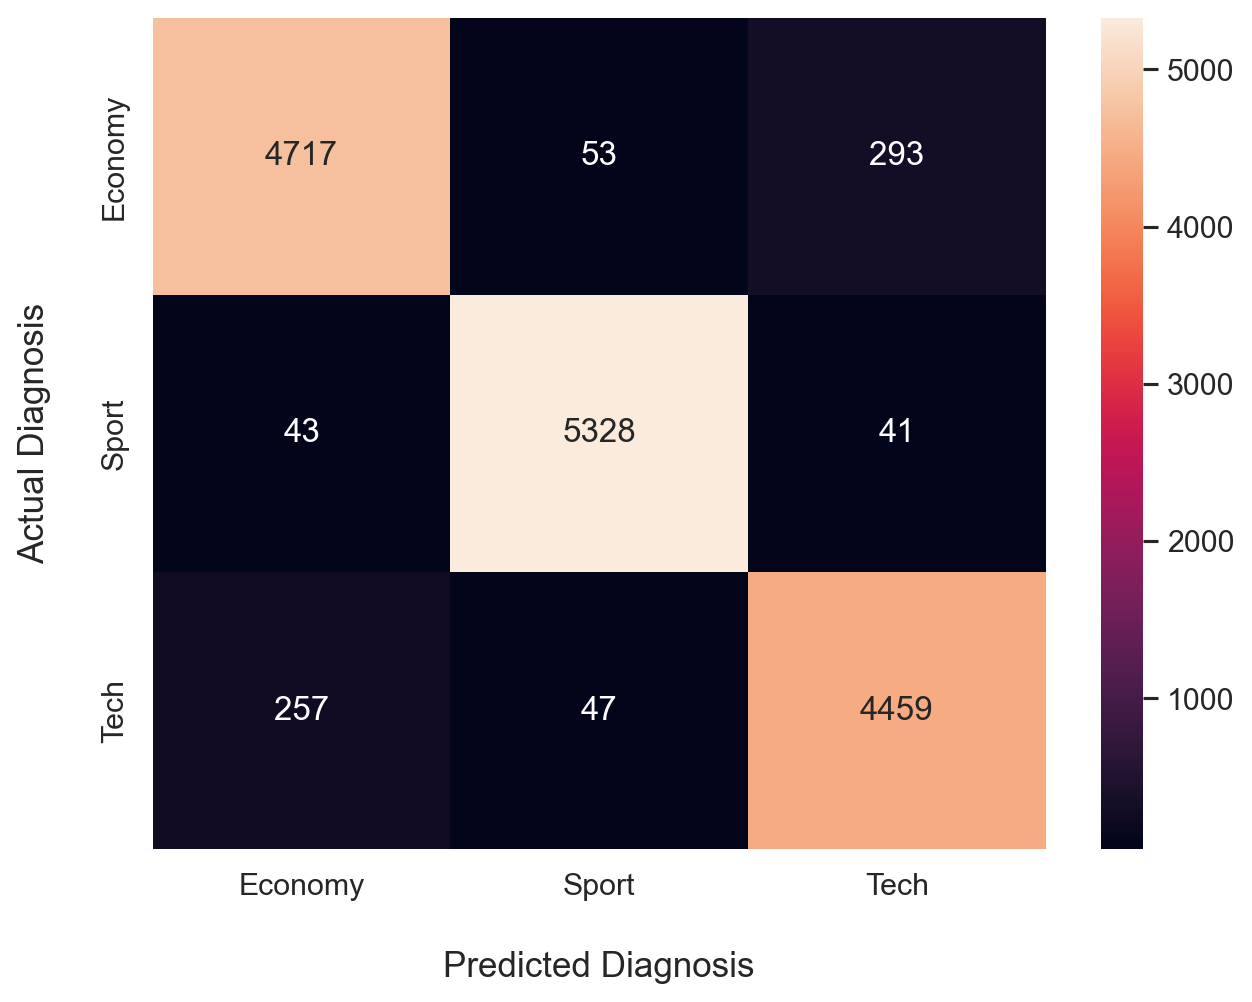

In [13]:
bayes.evalute(y_test, y_pred)

In [16]:
incorrect_pred = []
for real, pred, text in zip(y_test, y_pred, X_test):
    if real != pred:
        incorrect_pred.append((real, pred, text))

for category in bayes.categories:
    category_error = [err for err in incorrect_pred if err[0] == category]
    print(category + ": ")

    for real, pred, text in category_error:
        print(f"real is: {real}, predict is: {pred} - {text}") 

Economy: 
real is: Economy, predict is: Tech - ['دریافت کپی مدارک شناسایی بانکها متوقف شد/ اتصال سامانه اطلاعات هویتی ثبت احوال']
real is: Economy, predict is: Tech - ['ششمین نمایشگاه بین\u200cالمللی انرژی\u200cهای تجدیدپذیر برگزار']
real is: Economy, predict is: Tech - ['محرومان مسئولیم/ آفت تمرکزگرایی سیستم اداری']
real is: Economy, predict is: Tech - ['صیاد مجوز داریم/ بزرگترین پرورش دهنده شترمرغ']
real is: Economy, predict is: Tech - ['اجرای برنامه بارورسازی ابرها استان کشور']
real is: Economy, predict is: Sport - ['پایان حضور قانونی/ رای شورای\u200cعالی نظارت برکناری رئیس اتاق ایران']
real is: Economy, predict is: Tech - ['آموزش مهارت فارغ التحصیلان دانشگاهی کلید خورد']
real is: Economy, predict is: Tech - ['متر مکعب آب مجازی وارد کشور']
real is: Economy, predict is: Tech - ['حوزه تحول جدیدی رخ نداده']
real is: Economy, predict is: Tech - ['توسعه همکاری\u200c ایران اتحادیه اروپا انرژی\u200cهای نو']
real is: Economy, predict is: Tech - ['آغاز عرضه روغن جامد فروشگاه هفته آینده']
rea